## To explore possible variations

* Trying skip connections within double_conv_layers.
* stacking inception modules.

In [2]:
import os
import gc
import PIL
import tqdm
import torch
import random
import shutil
import torchvision
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# Unified Configuration Dictionary to change all the configurations in the code

CONFIG = {'model_type':'Vanilla_UNet',
          'epochs':30,
          'lr':5e-4,
          'weight_decay':1e-5,
          'batch_size_train':64,
          'batch_size_eval':256,
          'device':"cuda" if torch.cuda.is_available() else 'cpu'}

In [4]:
def print_shape(verbose, to_print):
  if verbose:
    print(to_print)

def double_conv_layers(in_channels, out_channels, kernel_size, activation, padding='same', batch_norm=True):
  '''
  Return Double Convolutional layers given the input parameters

  in_channels: input channels for the first convolutional layer
  out_channels: output channels for the second convolutional layer
  kernel_size: kernel size to use for both the layers
  activation: activaiton to apply to both the layers, should pass a activation function and not string.
  padding: padding to be applied to the inputs, by default no padding.
  batch_norm: if True applies nn.BatchNorm2d() after every Convolutional layer.
  '''

  if batch_norm:
    double_conv = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                                nn.BatchNorm2d(out_channels),
                                activation(inplace=True),
                                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                                nn.BatchNorm2d(out_channels),
                                activation(inplace=True))
  else:
    double_conv = nn.Sequential(
                                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                                activation(inplace=True),
                                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                                activation(inplace=True))
  
  return double_conv


class InceptionModule(nn.Module):
  def __init__(self, input_channels, verbose=False):
    super().__init__()
    
    self.verbose = verbose
    
    if input_channels % 4 == 0:
      out_channels = [int(input_channels/4) for i in range(4)]
    else:
      out_channels = [int(input_channels//4) if i<3 else input_channels - (3*int(input_channels//4)) for i in range(4)]


    self.channel_1 = nn.Conv2d(in_channels=input_channels, out_channels=out_channels[0], kernel_size=1, stride=1, padding='same')

    self.channel_2 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=out_channels[1], kernel_size=1, stride=1, padding='same'),
                              nn.Conv2d(in_channels=out_channels[1], out_channels=out_channels[1], kernel_size=3, stride=1, padding='same'))
    
    self.channel_3 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=out_channels[2], kernel_size=1, stride=1, padding='same'),
                              nn.Conv2d(in_channels=out_channels[2], out_channels=out_channels[2], kernel_size=5, stride=1, padding='same'))
    
    self.channel_4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                              nn.Conv2d(in_channels=input_channels, out_channels=out_channels[3], kernel_size=1, stride=1, padding='same'))
    
  def forward(self, input):
    print_shape(self.verbose, f'input shape : {input.shape}')
    x1 = self.channel_1(input)
    print_shape(self.verbose, f'Channel 1 : {x1.shape}')
    x2 = self.channel_2(input)
    print_shape(self.verbose, f'Channel 2 : {x2.shape}')
    x3 = self.channel_3(input)
    print_shape(self.verbose, f'Channel 3 : {x3.shape}')
    x4 = self.channel_4(input)
    print_shape(self.verbose, f'Channel 4 : {x4.shape}')
    x = torch.cat([x1, x2, x3, x4], 1)
    print_shape(self.verbose, f'Final shape : {x.shape}')
    return x

class UNet(nn.Module):
  def __init__(self, 
               down_conv_out=[64, 128, 256, 512], 
               down_conv_ks=[3, 3, 3, 3],
               down_conv_activation=nn.ReLU,
               up_conv_out=[256, 128, 64],
               up_conv_ks=[3, 3, 3],
               up_conv_activation=nn.ReLU,
               pad='same',
               add_inception=False,
               verbose=False):
    super().__init__()
    

    self.down_conv_out = down_conv_out
    self.down_conv_ks = down_conv_ks
    self.down_conv_activation = down_conv_activation
    self.up_conv_out = up_conv_out
    self.up_conv_ks = up_conv_ks
    self.up_conv_activation = up_conv_activation
    self.pad = pad
    self.add_inception = add_inception
    self.verbose = verbose

    # Down Conv Layers
    self.down_conv1 = double_conv_layers(3, down_conv_out[0], down_conv_ks[0], down_conv_activation, padding=pad)
    self.down_conv2 = double_conv_layers(down_conv_out[0], down_conv_out[1], down_conv_ks[1], down_conv_activation, padding=pad)
    self.down_conv3 = double_conv_layers(down_conv_out[1], down_conv_out[2], down_conv_ks[2], down_conv_activation, padding=pad)
    self.down_conv4 = double_conv_layers(down_conv_out[2], down_conv_out[3], down_conv_ks[3], down_conv_activation, padding=pad)

    # Inception Modules
    self.inception_module_1 = InceptionModule(down_conv_out[0])
    self.inception_module_2 = InceptionModule(down_conv_out[1])
    self.inception_module_3 = InceptionModule(down_conv_out[2])
    
    # Conv Transpose layers
    self.up_transpose1 = nn.ConvTranspose2d(down_conv_out[3], up_conv_out[0], 2, 2)
    self.up_transpose2 = nn.ConvTranspose2d(up_conv_out[0], up_conv_out[1], 2, 2)
    self.up_transpose3 = nn.ConvTranspose2d(up_conv_out[1], up_conv_out[2], 2, 2)
    
    # Up Conv Layers
    self.up_conv1 = double_conv_layers(down_conv_out[3], up_conv_out[0], up_conv_ks[0], up_conv_activation, padding=pad)
    self.up_conv2 = double_conv_layers(up_conv_out[0], up_conv_out[1], up_conv_ks[1], up_conv_activation, padding=pad)
    self.up_conv3 = double_conv_layers(up_conv_out[1], up_conv_out[2], up_conv_ks[2], up_conv_activation, padding=pad)

    # final output conv
    self.output_conv = nn.Conv2d(up_conv_out[2], 3, 1)

    # Maxpooling
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, input):

    # Down Conv Encoder Part
    print_shape(self.verbose, f'Start : {input.shape}')
    x1 = self.down_conv1(input)
    if self.add_inception:
      x1 = self.inception_module_1(x1)
    print_shape(self.verbose, f'After Down Conv 1 : {x1.shape}')
    x = self.maxpool(x1)
    print_shape(self.verbose, f'After maxpool : {x.shape}')
    x2 = self.down_conv2(x)
    if self.add_inception:
      x2 = self.inception_module_2(x2)
    print_shape(self.verbose, f'After Down Conv 2 : {x2.shape}')
    x = self.maxpool(x2)
    print_shape(self.verbose, f'After maxpool : {x.shape}')
    x3 = self.down_conv3(x)
    if self.add_inception:
      x3 = self.inception_module_3(x3)
    print_shape(self.verbose, f'After Down Conv 3 : {x3.shape}')
    x = self.maxpool(x3)
    print_shape(self.verbose, f'After maxpool : {x.shape}')
    x4 = self.down_conv4(x)
    print_shape(self.verbose, f'After Down Conv 4 : {x4.shape}')

    # Up Conv Decoder Part
    x = self.up_transpose1(x4)
    print_shape(self.verbose, f'After Up Transpose 1 : {x.shape}')
    x = self.up_conv1(torch.cat([x, x3], 1)) # skip connection from down_conv3
    print_shape(self.verbose, f'After Up Conv 1 : {x.shape}')
    x = self.up_transpose2(x)
    print_shape(self.verbose, f'After Up Transpose 2 : {x.shape}')
    x = self.up_conv2(torch.cat([x, x2], 1)) # skip connection from down_conv2
    print_shape(self.verbose, f'After Up Conv 2 : {x.shape}')
    x = self.up_transpose3(x)
    print_shape(self.verbose, f'After Up Transpose 3 : {x.shape}')
    x = self.up_conv3(torch.cat([x, x1], 1)) # skip connection from down_conv1
    print_shape(self.verbose, f'After Up Conv 3 : {x.shape}')

    # final output conv layer
    x = self.output_conv(x)
    print_shape(self.verbose, f'After Final output conv : {x.shape}')

    return x

In [5]:
# without inception modules
image = torch.zeros(1, 3, 128, 128)
model = UNet(add_inception=False, verbose=True)
x = model(image)

Start : torch.Size([1, 3, 128, 128])
After Down Conv 1 : torch.Size([1, 64, 128, 128])
After maxpool : torch.Size([1, 64, 64, 64])
After Down Conv 2 : torch.Size([1, 128, 64, 64])
After maxpool : torch.Size([1, 128, 32, 32])
After Down Conv 3 : torch.Size([1, 256, 32, 32])
After maxpool : torch.Size([1, 256, 16, 16])
After Down Conv 4 : torch.Size([1, 512, 16, 16])
After Up Transpose 1 : torch.Size([1, 256, 32, 32])
After Up Conv 1 : torch.Size([1, 256, 32, 32])
After Up Transpose 2 : torch.Size([1, 128, 64, 64])
After Up Conv 2 : torch.Size([1, 128, 64, 64])
After Up Transpose 3 : torch.Size([1, 64, 128, 128])
After Up Conv 3 : torch.Size([1, 64, 128, 128])
After Final output conv : torch.Size([1, 3, 128, 128])


In [6]:
# with inception modules
image = torch.zeros(1, 3, 128, 128)
model = UNet(add_inception=True, verbose=True)
x = model(image)

Start : torch.Size([1, 3, 128, 128])
After Down Conv 1 : torch.Size([1, 64, 128, 128])
After maxpool : torch.Size([1, 64, 64, 64])
After Down Conv 2 : torch.Size([1, 128, 64, 64])
After maxpool : torch.Size([1, 128, 32, 32])
After Down Conv 3 : torch.Size([1, 256, 32, 32])
After maxpool : torch.Size([1, 256, 16, 16])
After Down Conv 4 : torch.Size([1, 512, 16, 16])
After Up Transpose 1 : torch.Size([1, 256, 32, 32])
After Up Conv 1 : torch.Size([1, 256, 32, 32])
After Up Transpose 2 : torch.Size([1, 128, 64, 64])
After Up Conv 2 : torch.Size([1, 128, 64, 64])
After Up Transpose 3 : torch.Size([1, 64, 128, 128])
After Up Conv 3 : torch.Size([1, 64, 128, 128])
After Final output conv : torch.Size([1, 3, 128, 128])


In [7]:
model = UNet(down_conv_out=[16, 32, 64, 128],
             down_conv_ks=[3, 3, 3, 3],
             down_conv_activation=nn.ReLU,
             up_conv_out=[64, 32, 16],
             up_conv_activation=nn.ReLU,
             verbose=True)
x = model(image)

Start : torch.Size([1, 3, 128, 128])
After Down Conv 1 : torch.Size([1, 16, 128, 128])
After maxpool : torch.Size([1, 16, 64, 64])
After Down Conv 2 : torch.Size([1, 32, 64, 64])
After maxpool : torch.Size([1, 32, 32, 32])
After Down Conv 3 : torch.Size([1, 64, 32, 32])
After maxpool : torch.Size([1, 64, 16, 16])
After Down Conv 4 : torch.Size([1, 128, 16, 16])
After Up Transpose 1 : torch.Size([1, 64, 32, 32])
After Up Conv 1 : torch.Size([1, 64, 32, 32])
After Up Transpose 2 : torch.Size([1, 32, 64, 64])
After Up Conv 2 : torch.Size([1, 32, 64, 64])
After Up Transpose 3 : torch.Size([1, 16, 128, 128])
After Up Conv 3 : torch.Size([1, 16, 128, 128])
After Final output conv : torch.Size([1, 3, 128, 128])


# Helper Functions

### function for generating masks

In [ ]:
!unzip /content/128x128_Train_Val_Dataset.zip

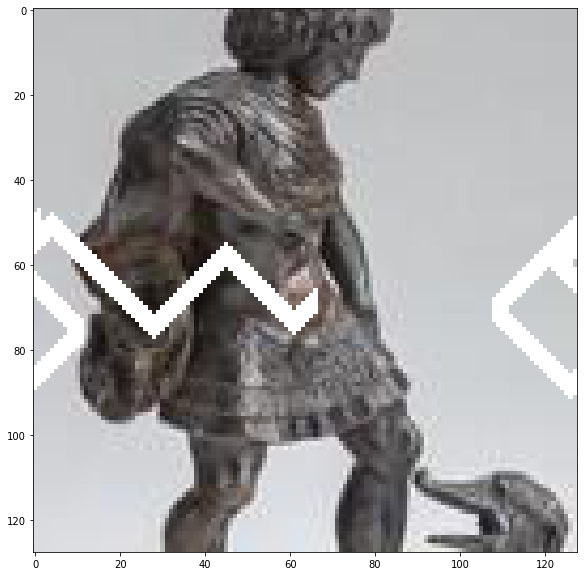

In [8]:
def update(arr, x, y):
  try: arr[x, y] = False
  except: pass
  return arr

def generate_mask(size):
  start_x_1 = np.random.randint(size//2, size-size//2.1)
  start_y_1 = np.random.randint(size//2, size-size//2.1)
  start_x_2 = start_x_1 + 1
  start_y_2 = start_y_1 + 0
  start_x_3 = start_x_2 + 1
  start_y_3 = start_y_2 + 0
  start_x_4 = start_x_3 + 1
  start_y_4 = start_y_3 + 0
  start_x_5 = start_x_4 + 1
  start_y_5 = start_y_4 + 0
  start_x_6 = start_x_5 + 1
  start_y_6 = start_y_5 + 0
  arr = np.full((size, size), True)
  arr = update(arr, start_x_1, start_y_1)
  arr = update(arr, start_x_2, start_y_2)
  arr = update(arr, start_x_3, start_y_3)
  arr = update(arr, start_x_4, start_y_4)
  arr = update(arr, start_x_5, start_y_5)
  arr = update(arr, start_x_6, start_y_6)
  x_1 = start_x_1
  y_1 = start_y_1
  x_2 = start_x_2
  y_2 = start_y_2
  x_3 = start_x_3
  y_3 = start_y_3
  x_4 = start_x_4
  y_4 = start_y_4
  x_5 = start_x_5
  y_5 = start_y_5
  x_6 = start_x_6
  y_6 = start_y_6
  for i in range(np.random.randint(10, 30)):
    x = -1 if np.random.choice([True, False]) else 1
    y = -1 if np.random.choice([True, False]) else 1
    for i in range(np.random.randint(5, 20)):
      x_1 += x
      y_1 += y
      x_2 += x
      y_2 += y
      x_3 += x
      y_3 += y
      x_4 += x
      y_4 += y
      x_5 += x
      y_5 += y
      x_6 += x
      y_6 += y
      arr = update(arr, x_1, y_1)
      arr = update(arr, x_2, y_2)
      arr = update(arr, x_3, y_3)
      arr = update(arr, x_4, y_4)
      arr = update(arr, x_5, y_5)
      arr = update(arr, x_6, y_6)
  return arr

image = plt.imread('/content/processed_dataset/fb737ad1-332d-4332-aa99-59d8a347c5be.jpg')
image = np.where(np.dstack([generate_mask(128)]*3), image, 255)
plt.figure(figsize=(16, 10))
plt.imshow(image)

In [9]:
CONFIG['masks'] = [torch.from_numpy(np.dstack([generate_mask(128)]*3)) for i in range(10000)]

### Making image data directories

Following code will create the different directories for training, test and validation data for ease of creating dataloaders using the torchvision.datasets.ImageFolder class.

In [10]:
def make_dataset_dirs(base_dir, original_dir, sub_dirs, image_name_lists):
  
  # check if the base dir exists or not, if not then create base dir
  if not os.path.exists(base_dir):
    os.mkdir(base_dir)
  

  # iterating through 3 different sub dirs for creating 3 different ImageFolder datasets
  for sub_dir, image_names in zip(sub_dirs, image_name_lists):

    dir = os.path.join(base_dir, sub_dir) 
    
    # checking if directory exists or not, if not create the sub directory
    if not os.path.exists(dir):
      os.mkdir(dir)

    dir = os.path.join(dir, 'artwork')
    if not os.path.exists(dir):
      os.mkdir(dir)

    # store the image in the new path
    for image_name in image_names:
      source = os.path.join(original_dir, image_name)
      destination = os.path.join(dir, image_name)
      shutil.copyfile(source, destination)

train_images, test_images = train_test_split(os.listdir('/content/processed_dataset'), test_size=0.2)
train_images, val_images = train_test_split(train_images, test_size=0.2)

original_dir = '/content/processed_dataset'
base_dir = 'artwork_datasets'
sub_dirs = ['train', 'validation', 'test']
image_name_lists = [train_images, val_images, test_images]

make_dataset_dirs(base_dir, original_dir, sub_dirs, image_name_lists)

In [10]:
# apply the transformations needed
transform = transforms.Compose([transforms.ToTensor()])

# create the Training, Validation and Testing datasets from the respective paths
train_dataset = datasets.ImageFolder('/content/artwork_datasets/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/artwork_datasets/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/artwork_datasets/test', transform=transform)

# create the Training, Validation and Testing dataloaders from the respective datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=CONFIG['batch_size_train'], drop_last=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=CONFIG['batch_size_eval'], drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=CONFIG['batch_size_eval'], drop_last=True)

### training and validation code

In [10]:
def get_masked_inputs(targets, masks):
  '''
  This function outputs the masked inputs.

  targets : original images which have not been masked
  masks : buffer of masks out of which masks will be samples to mask the original image to create the input masked image
  '''
  i = [random.choice(range(len(targets))) for i in range(len(targets))]
  masks = np.array(masks)
  masks = list(masks[i])
  masks = torch.stack(masks)
  masks = torch.permute(masks, (0, 3, 1, 2))

  # get masked_inputs
  masked_inputs = torch.tensor(torch.where(masks, targets, 1.0), requires_grad=True)

  return masked_inputs

def train_one_epoch(model, dataloader, epoch, masks, optimizer, criterion):
  model.train()

  total_loss = 0
  batches_iterated = 1
  bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

  for step, batch in bar:
    targets = batch[0].to(float)
    masked_inputs = get_masked_inputs(targets, masks)
    masked_inputs = masked_inputs.to(device=CONFIG['device'], dtype=torch.float)
    targets = torch.tensor(targets, requires_grad=True).to(device=CONFIG['device'], dtype=torch.float)
    #print(masked_inputs.requires_grad, targets.requires_grad)
    preds = model(masked_inputs)

    loss = criterion(preds, targets)
    
    # backpropogate the loss
    loss.backward()

    # update the gradients
    optimizer.step()
    optimizer.zero_grad() # make the gradients for every param 0

    total_loss += loss
    batches_iterated += step
    epoch_loss = total_loss / batches_iterated

    bar.set_postfix(Epoch=epoch, Train_loss=epoch_loss.item())

    gc.collect()
    torch.cuda.empty_cache()
  return epoch_loss

@torch.no_grad()
def val_one_epoch(model, dataloader, epoch, masks, criterion):
  model.eval()

  total_loss = 0
  batches_iterated = 1
  bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))

  for step, batch in bar:
    targets = batch[0].to(float)
    masked_inputs = get_masked_inputs(targets, masks)
    masked_inputs = masked_inputs.to(device=CONFIG['device'], dtype=torch.float)
    targets = targets.to(device=CONFIG['device'], dtype=torch.float)

    preds = model(masked_inputs)
    loss = criterion(preds, targets)

    total_loss += loss
    batches_iterated += step
    epoch_loss = total_loss / batches_iterated

    bar.set_postfix(Epoch=epoch, Validation_loss=epoch_loss.item())
    
    gc.collect()
    torch.cuda.empty_cache()
  return epoch_loss


In [ ]:
# Training Loop
torch.cuda.empty_cache()
model = UNet(down_conv_out=[16, 32, 64, 128],
             down_conv_ks=[3, 3, 3, 3],
             down_conv_activation=nn.ReLU,
             up_conv_out=[64, 32, 16],
             up_conv_activation=nn.ReLU,
             verbose=False).to(device=CONFIG['device'])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

train_loss_list = []
val_loss_list = []

for epoch in range(CONFIG['epochs']):

  train_loss = train_one_epoch(model, train_dataloader, epoch, CONFIG['masks'], optimizer, criterion)
  val_loss = val_one_epoch(model, val_dataloader, epoch, CONFIG['masks'], criterion)

  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)

  if epoch > 5:
    torch.save(model.state_dict(), f'{CONFIG["model_type"]}_epoch_{epoch}_.pth')

  0%|          | 0/2015 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launc